In [1]:
import zarr
from pyprojroot import here
import pandas as pd
import numpy as np
import allel
import yaml
import matplotlib.pyplot as plt
import functools
import seaborn as sns
sns.set_context('paper')
import dask.array as da
import scipy.interpolate
import scipy.stats
import petl as etl
import pyfasta
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
genome_path = here() / 'data/external/vectorbase/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa'
genome = pyfasta.Fasta(str(genome_path), key_fn=lambda x: x.split()[0])
genome

In [3]:
chromosomes = '2', '3', 'X'
chromosome_plen = {
    '2': len(genome['2R']) + len(genome['2L']), 
    '3': len(genome['3R']) + len(genome['3L']), 
    'X': len(genome['X'])
}

In [4]:
pop_defs_path = here() / 'notebooks/gwss/pop_defs.yml'
with open(pop_defs_path, 'rt') as f:
    pop_defs = yaml.safe_load(f)
pops = list(pop_defs)
pops

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [5]:
h12_root_path = here() / 'data/gwss/h12/h12.zarr'
h12_root = zarr.open_consolidated(str(h12_root_path))

    
def load_h12_gwss(pop, chromosome):
    window_size = pop_defs[pop]['h12_window_size']
    window_step = 200
    grp = h12_root[f'{pop}/{window_size}/{window_step}/{chromosome}']
    return (
        grp['windows'][:],
        grp['gwindows'][:],
        grp['h1'][:],
        grp['h12'][:],
        grp['h123'][:],
        grp['h2_h1'][:]
    )

In [182]:
def plot_h12(pop, chromosome, ax=None, markersize=.5, legend=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2), facecolor='w')
    palette = sns.color_palette("Reds", 3)[:]
    windows, gwindows, h1, h12, h123, h2_h1 = load_h12_gwss(pop, chromosome)
    x = windows.mean(axis=1) / 1e6
    ax.plot(x, h123, linestyle=' ', marker='o', color=palette[0], markersize=markersize, label='H123')
    ax.plot(x, h12, linestyle=' ', marker='o', color=palette[1], markersize=markersize, label='H12')
    ax.plot(x, h1, linestyle=' ', marker='o', color=palette[2], markersize=markersize, label='H1')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.set_xlim(0, chromosome_plen[chromosome] / 1e6)
    ax.set_ylim(0, 1)
    if legend:
        lgd = ax.legend(bbox_to_anchor=(1, 1), loc='upper left', facecolor='w', edgecolor='w')
        for handle in lgd.legendHandles:
            handle._legmarker.set_markersize(6)
    

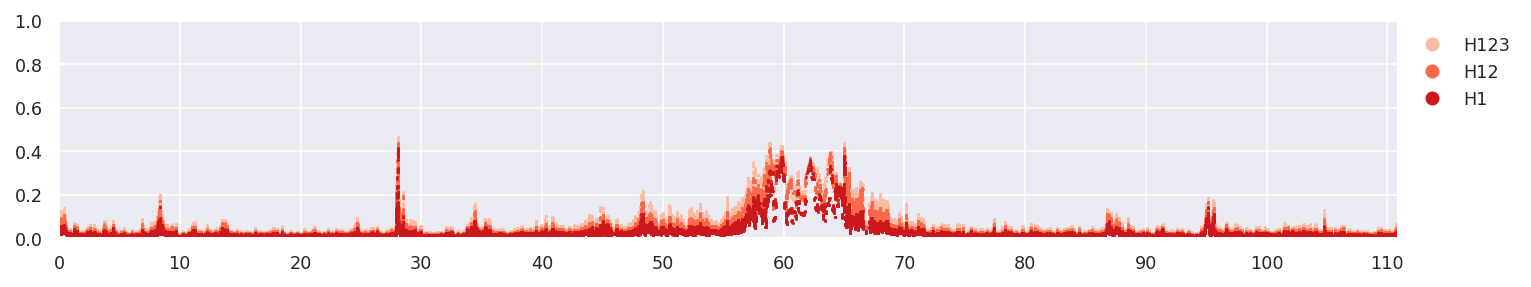

In [183]:
plot_h12('ao_col', '2', legend=True)

In [10]:
ihs_root_path = here() / 'data/gwss/ihs/ihs.zarr'
ihs_root = zarr.open_consolidated(str(ihs_root_path))


@functools.lru_cache(maxsize=None)
def load_ihs_gwss(pop, chromosome, window_size=200, window_step=100):
    grp = ihs_root[f'{pop}/{chromosome}']
    pos = grp['pos'][:]
    ihs_std = np.fabs(grp['ihs_std'][:])
    x = allel.moving_statistic(pos, np.mean, size=window_size, step=window_step)
    y_max = allel.moving_statistic(ihs_std, np.max, size=window_size, step=window_step)
    y_pc95 = allel.moving_statistic(ihs_std, lambda v: np.percentile(v, 95), size=window_size, step=window_step)
    y_pc75 = allel.moving_statistic(ihs_std, lambda v: np.percentile(v, 75), size=window_size, step=window_step)
    y_pc50 = allel.moving_statistic(ihs_std, np.median, size=window_size, step=window_step)
    return x, y_max, y_pc95, y_pc75, y_pc50


In [178]:
def plot_ihs(pop, chromosome, ax=None, markersize=.5, window_size=200, window_step=100, legend=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2), facecolor='w')
    palette = sns.color_palette("Blues", 4)[:]
    x, y_max, y_pc95, y_pc75, y_pc50 = load_ihs_gwss(pop, chromosome, window_size=window_size, window_step=window_step)
    x = x/1e6
    ax.plot(x, y_max.clip(0, 10), marker='o', linestyle=' ', markersize=markersize, color=palette[0], label='$P_{100}$')
    ax.plot(x, y_pc95.clip(0, 10), marker='o', linestyle=' ', markersize=markersize, color=palette[1], label='$P_{95}$')
    ax.plot(x, y_pc75.clip(0, 10), marker='o', linestyle=' ', markersize=markersize, color=palette[2], label='$P_{75}$')
    ax.plot(x, y_pc50.clip(0, 10), marker='o', linestyle=' ', markersize=markersize, color=palette[3], label='$P_{50}$')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.set_xlim(0, chromosome_plen[chromosome] / 1e6)
    ax.set_ylim(0, 10)
    if legend:
        lgd = ax.legend(bbox_to_anchor=(1, 1), loc='upper left', facecolor='w', edgecolor='w')
        for handle in lgd.legendHandles:
            handle._legmarker.set_markersize(6)
    

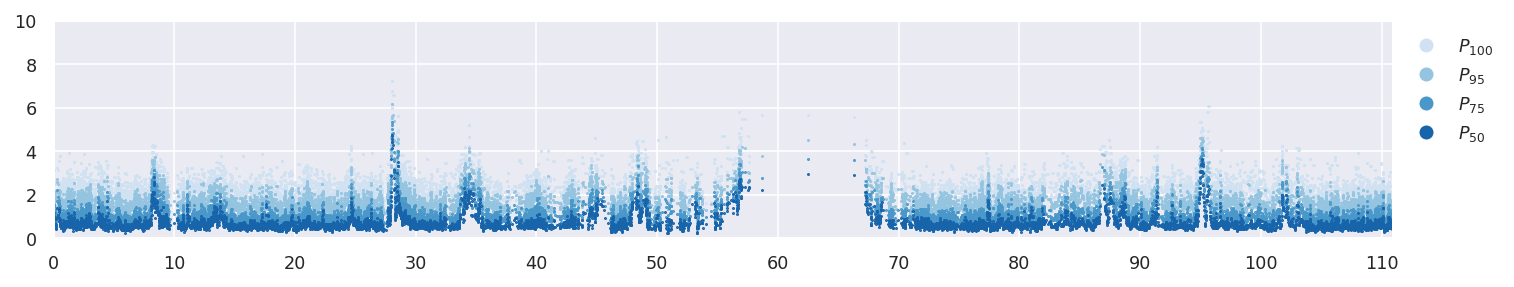

In [179]:
plot_ihs('ao_col', '2', legend=True)

In [13]:
xpehh_root_path = here() / 'data/gwss/xpehh/xpehh.zarr'
xpehh_root = zarr.open_consolidated(str(xpehh_root_path))


@functools.lru_cache(maxsize=None)
def load_xpehh_gwss(pop1, pop2, chromosome, window_size=500, window_step=250):

    # avoid running the same scan twice
    orig_pop1, orig_pop2 = pop1, pop2
    pop1, pop2 = sorted([pop1, pop2])
    
    grp = xpehh_root[f'{pop1}_{pop2}/{chromosome}']
    pos = grp['pos'][:]
    xpehh = grp['xpehh'][:]

    if pop1 == orig_pop2:
        # flip back
        xpehh = -xpehh
        pop1, pop2 = pop2, pop1

    # centre
    xpehh = xpehh - np.median(xpehh)
    
    # clip at zero to focus on selection in pop1
    xpehh1 = np.clip(xpehh, a_min=0, a_max=None)
    
    x = allel.moving_statistic(pos, np.mean, size=window_size, step=window_step)
    y_max = allel.moving_statistic(xpehh1, np.max, size=window_size, step=window_step)
    y_pc95 = allel.moving_statistic(xpehh1, lambda v: np.percentile(v, 95), size=window_size, step=window_step)
    y_pc75 = allel.moving_statistic(xpehh1, lambda v: np.percentile(v, 75), size=window_size, step=window_step)
    y_pc50 = allel.moving_statistic(xpehh1, np.median, size=window_size, step=window_step)
    
    return x, y_max, y_pc95, y_pc75, y_pc50


In [180]:
def plot_xpehh(pop1, pop2, chromosome, ax=None, markersize=.5, window_size=500, window_step=250, legend=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2), facecolor='w')
    palette = sns.color_palette("Greens", 4)[:]
    x, y_max, y_pc95, y_pc75, y_pc50 = load_xpehh_gwss(pop1, pop2, chromosome, window_size=window_size, window_step=window_step)
    x = x/1e6
    ax.plot(x, y_max.clip(0, 6), marker='o', linestyle=' ', markersize=markersize, color=palette[0], label='$P_{100}$')
    ax.plot(x, y_pc95.clip(0, 6), marker='o', linestyle=' ', markersize=markersize, color=palette[1], label='$P_{95}$')
    ax.plot(x, y_pc75.clip(0, 6), marker='o', linestyle=' ', markersize=markersize, color=palette[2], label='$P_{75}$')
    ax.plot(x, y_pc50.clip(0, 6), marker='o', linestyle=' ', markersize=markersize, color=palette[3], label='$P_{50}$')
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.set_xlim(0, chromosome_plen[chromosome] / 1e6)
    ax.set_ylim(0, 6)
    if legend:
        lgd = ax.legend(bbox_to_anchor=(1, 1), loc='upper left', facecolor='w', edgecolor='w')
        for handle in lgd.legendHandles:
            handle._legmarker.set_markersize(6)
    

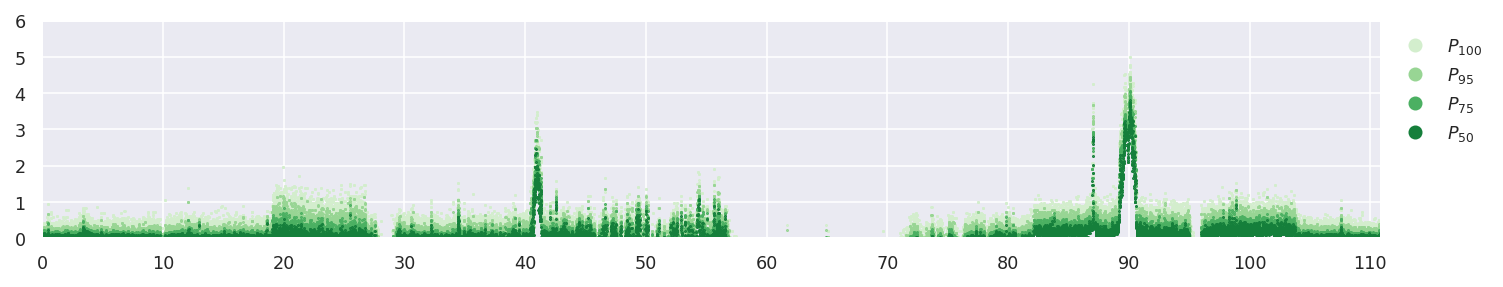

In [181]:
plot_xpehh('bf_gam', 'ug_gam', '2', legend=True)

In [19]:
pbs_root_path = here() / 'data/gwss/pbs/pbs.zarr'
pbs_root = zarr.open_consolidated(str(pbs_root_path))


def load_pbs_gwss(pop1, pop2, pop3, chromosome, window_size=500, window_step=250):

    grp_path = f'/{pop1}_{pop2}_{pop3}/{window_size}/{window_step}/{chromosome}'
    grp = pbs_root[grp_path]
    windows = grp['windows'][:]
    gwindows = grp['gwindows'][:]
    pbs = grp['pbs'][:]
    pbs_scaled = grp['pbs_scaled'][:]
    
    return windows, gwindows, pbs, pbs_scaled


In [20]:
def plot_pbs(pop1, pop2, pop3, chromosome, ax=None, markersize=.5, window_size=500, window_step=250):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 2), facecolor='w')
    palette = sns.color_palette("Greens", 5)[1:]
    windows, gwindows, pbs, pbs_scaled = load_pbs_gwss(
        pop1, pop2, pop3, chromosome, window_size=window_size, window_step=window_step
    )
    x = windows.mean(axis=1)/1e6
    palette = sns.color_palette()
    ax.plot(x, pbs_scaled.clip(0, 50), marker='o', linestyle=' ', markersize=markersize, 
            color=palette[4])
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.set_xlim(0, chromosome_plen[chromosome] / 1e6)
    ax.set_ylim(0, 50)
    

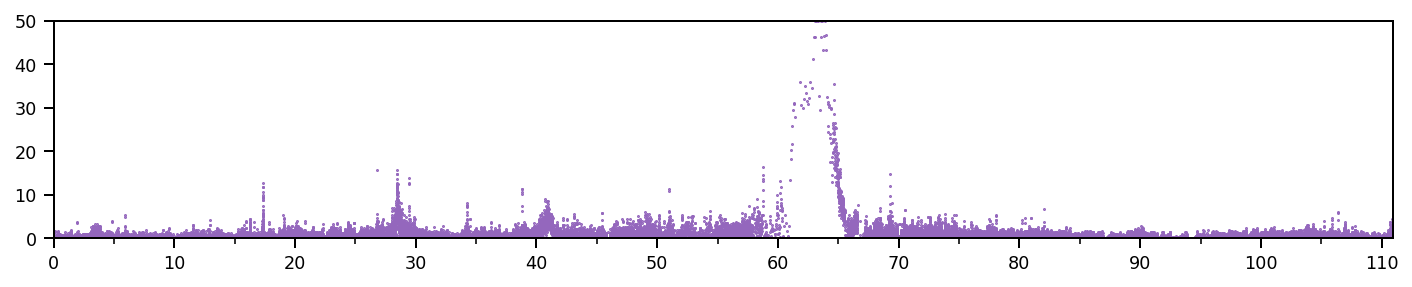

In [21]:
plot_pbs('bf_gam', 'ug_gam', 'gq_gam', '2')

In [43]:
def load_genes():

    features_path = here() / 'data/external/vectorbase/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.12.gff3'
    df_genes = (
        allel.gff3_to_dataframe(
            str(features_path),
            attributes=['ID']
        )
        .set_index('ID')
        .query("type == 'gene'")
    )

    # convert to chromosomal coordinates
    df_genes['chromosome'] = df_genes['seqid'].copy()
    df_genes['chromosome_start'] = df_genes['start'].copy()
    df_genes['chromosome_end'] = df_genes['end'].copy()
    loc_2R = df_genes.seqid == '2R'
    df_genes.loc[loc_2R, 'chromosome'] = '2'
    loc_2L = df_genes.seqid == '2L'
    df_genes.loc[loc_2L, 'chromosome'] = '2'
    df_genes.loc[loc_2L, 'chromosome_start'] = df_genes.loc[loc_2L, 'start'] + len(genome['2R'])
    df_genes.loc[loc_2L, 'chromosome_end'] = df_genes.loc[loc_2L, 'end'] + len(genome['2R'])
    loc_3R = df_genes.seqid == '3R'
    df_genes.loc[loc_3R, 'chromosome'] = '3'
    loc_3L = df_genes.seqid == '3L'
    df_genes.loc[loc_3L, 'chromosome'] = '3'
    df_genes.loc[loc_3L, 'chromosome_start'] = df_genes.loc[loc_3L, 'start'] + len(genome['3R'])
    df_genes.loc[loc_3L, 'chromosome_end'] = df_genes.loc[loc_3L, 'end'] + len(genome['3R'])
    
    return df_genes


df_genes = load_genes()
df_genes

,seqid,source,type,start,end,score,strand,phase,chromosome,chromosome_start,chromosome_end
ID,,,,,,,,,,,
AGAP004677,2L,VectorBase,gene,157348,186936,-1,-,-1,2,61702453,61732041
AGAP004678,2L,VectorBase,gene,203779,205293,-1,+,-1,2,61748884,61750398
AGAP004679,2L,VectorBase,gene,207894,210460,-1,+,-1,2,61752999,61755565
AGAP004680,2L,VectorBase,gene,271285,271815,-1,+,-1,2,61816390,61816920
AGAP004681,2L,VectorBase,gene,358329,359280,-1,-,-1,2,61903434,61904385
...,...,...,...,...,...,...,...,...,...,...,...
AGAP001092,X,VectorBase,gene,24086190,24087589,-1,+,-1,X,24086190,24087589
AGAP001093,X,VectorBase,gene,24094799,24142048,-1,+,-1,X,24094799,24142048
AGAP001094,X,VectorBase,gene,24231498,24256349,-1,-,-1,X,24231498,24256349


In [44]:
df_genes.loc['AGAP001356']

seqid                       2R
source              VectorBase
type                      gene
start                  3483099
end                    3497400
score                       -1
strand                       +
phase                       -1
chromosome                   2
chromosome_start       3483099
chromosome_end         3497400
Name: AGAP001356, dtype: object

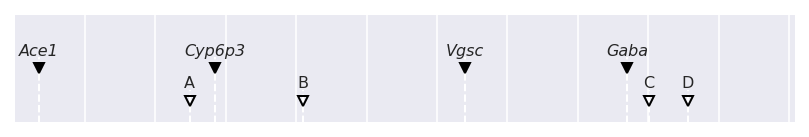

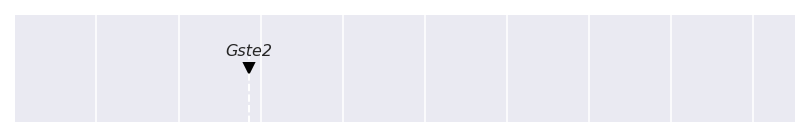

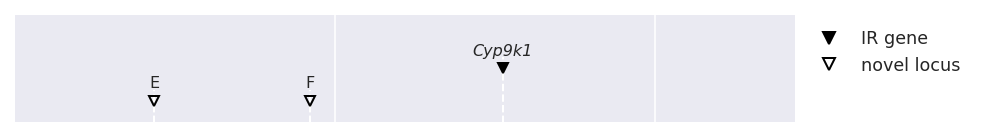

In [200]:
annotate_genes = {
    'AGAP001356': 'Ace1',
    'AGAP002865': 'Cyp6p3',
    'AGAP004707': 'Vgsc',
    'AGAP006028': 'Gaba',
    'AGAP009194': 'Gste2',
    'AGAP000818': 'Cyp9k1',
}


novel_loci = {
    'A': ('2', 24_860_000),
    'B': ('2', 40_940_000),
    'C': ('2', 28_549_590 + len(genome['2R'])),
    'D': ('2', 34_050_000 + len(genome['2R'])),
    'E': ('X', 4_360_000),
    'F': ('X', 9_220_000),
}


def guide_loci(chromosome, ax, genes_ymax=1, novel_loci_ymax=1):
    for gene_id, gene_label in annotate_genes.items():
        gene = df_genes.loc[gene_id]
        if gene.chromosome == chromosome:
            x = (gene.chromosome_start + gene.chromosome_end) / 2e6
            ax.axvline(x, ymin=0, ymax=genes_ymax, color='w', linestyle='--', linewidth=1)
    for locus_label, (locus_chromosome, locus_pos) in novel_loci.items():
        if locus_chromosome == chromosome:
            x = locus_pos / 1e6
            ax.axvline(x, ymin=0, ymax=novel_loci_ymax, color='w', linestyle='--', linewidth=1)
    
    
def plot_loci(chromosome, ax=None, legend=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 1), facecolor='w')
    guide_loci(chromosome, ax=ax, genes_ymax=.6, novel_loci_ymax=.3)
    for gene_id, gene_label in annotate_genes.items():
        gene = df_genes.loc[gene_id]
        if gene.chromosome == chromosome:
            x = (gene.chromosome_start + gene.chromosome_end) / 2e6
            y = .5
            ax.plot([x], [y], marker='v', linestyle=' ', color='k')
            ax.annotate(gene_label, xy=(x, y), xytext=(0, 5), textcoords='offset points', 
                        fontstyle='italic', ha='center', va='bottom', fontsize=8)
    for locus_label, (locus_chromosome, locus_pos) in novel_loci.items():
        if locus_chromosome == chromosome:
            x = locus_pos / 1e6
            y = .2
            ax.plot([x], [y], marker='v', linestyle=' ', mec='k', mfc='none')
            ax.annotate(locus_label, xy=(x, y), xytext=(0, 5), textcoords='offset points', 
                        ha='center', va='bottom', fontsize=8)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, chromosome_plen[chromosome]/1e6)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    if legend:
        from matplotlib.lines import Line2D
        gene_marker = Line2D([], [], linestyle=' ', marker='v', color='k', label='IR gene',
                             markersize=6)
        novel_locus_marker = Line2D([], [], linestyle=' ', marker='v', mfc='none', 
                                    mec='k', label='novel locus', markersize=6)
        ax.legend(handles=[gene_marker, novel_locus_marker], bbox_to_anchor=(1, 1), 
                  loc='upper left', facecolor='w', edgecolor='w')
    
    
plot_loci('2')
plot_loci('3')
plot_loci('X', legend=True)

In [228]:
def fig_gwss(pop, xpehh_pop, pbs_pops, markersize=.5, figsize=(12, 7), savefig=True, savefig_dpi=150):
    
    fig = plt.figure(figsize=figsize, facecolor='w')
    width_ratios = [chromosome_plen[c] for c in chromosomes]
    gs = fig.add_gridspec(ncols=3, nrows=5, width_ratios=width_ratios, height_ratios=[1.5, 3, 3, 3, 3])
    
    # Genes
    
    ax = fig.add_subplot(gs[0, 0])
    plot_loci(chromosome='2', ax=ax)
    ax.set_title('Chromosome 2')
    
    ax = fig.add_subplot(gs[0, 1])
    plot_loci(chromosome='3', ax=ax)
    ax.set_title('Chromosome 3')
    
    ax = fig.add_subplot(gs[0, 2])
    plot_loci(chromosome='X', ax=ax, legend=True)
    ax.set_title('Chromosome X')
    
    # H12
    
    ax = fig.add_subplot(gs[1, 0])
    guide_loci('2', ax=ax)
    plot_h12(pop, chromosome='2', ax=ax, markersize=markersize)
    ax.set_ylabel('$H12$')
    ax.set_xticklabels([])

    ax = fig.add_subplot(gs[1, 1])
    guide_loci('3', ax=ax)
    plot_h12(pop, chromosome='3', ax=ax, markersize=markersize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)

    ax = fig.add_subplot(gs[1, 2])
    guide_loci('X', ax=ax)
    plot_h12(pop, chromosome='X', ax=ax, markersize=markersize, legend=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    
    # iHS
    
    ax = fig.add_subplot(gs[2, 0])
    guide_loci('2', ax=ax)
    plot_ihs(pop, chromosome='2', ax=ax, markersize=markersize)
    ax.set_ylabel('$|iHS|$')
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(gs[2, 1])
    guide_loci('3', ax=ax)
    plot_ihs(pop, chromosome='3', ax=ax, markersize=markersize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    ax = fig.add_subplot(gs[2, 2])
    guide_loci('X', ax=ax)
    plot_ihs(pop, chromosome='X', ax=ax, markersize=markersize, legend=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    # XPEHH

    ax = fig.add_subplot(gs[3, 0])
    guide_loci('2', ax=ax)
    plot_xpehh(pop, xpehh_pop, chromosome='2', ax=ax, markersize=markersize)
    ax.set_ylabel('$XP-EHH$')
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(gs[3, 1])
    guide_loci('3', ax=ax)
    plot_xpehh(pop, xpehh_pop, chromosome='3', ax=ax, markersize=markersize)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    ax = fig.add_subplot(gs[3, 2])
    guide_loci('X', ax=ax)
    plot_xpehh(pop, xpehh_pop, chromosome='X', ax=ax, markersize=markersize, legend=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    # PBS
    pop2, pop3 = pbs_pops

    ax = fig.add_subplot(gs[4, 0])
    guide_loci('2', ax=ax)
    plot_pbs(pop, pop2, pop3, chromosome='2', ax=ax, markersize=markersize)
    ax.set_ylabel('$PBS$')
    ax.set_xlabel(f'Position (Mbp)')
    
    ax = fig.add_subplot(gs[4, 1])
    guide_loci('3', ax=ax)
    plot_pbs(pop, pop2, pop3, chromosome='3', ax=ax, markersize=markersize)
    ax.set_xlabel(f'Position (Mbp)')
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    ax = fig.add_subplot(gs[4, 2])
    guide_loci('X', ax=ax)
    plot_pbs(pop, pop2, pop3, chromosome='X', ax=ax, markersize=markersize)
    ax.set_xlabel(f'Position (Mbp)')
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)
    
    pop_label = (
        pop_defs[pop]["label"]
        .replace('An. gambiae', '$An. gambiae$')
        .replace('An. coluzzii', '$An. coluzzii$')
    )
    fig.suptitle(pop_label, y=.96)
    fig.tight_layout()
    
    if savefig:
        pbs_pop2, pbs_pop3 = pbs_pops
        file_path = here() / f'artwork/gwss_{pop}_{xpehh_pop}_{pbs_pop2}_{pbs_pop3}.png'
        fig.savefig(file_path, bbox_inches='tight', dpi=savefig_dpi)


In [229]:
sns.set_style('darkgrid')

In [230]:
list(pop_defs)

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

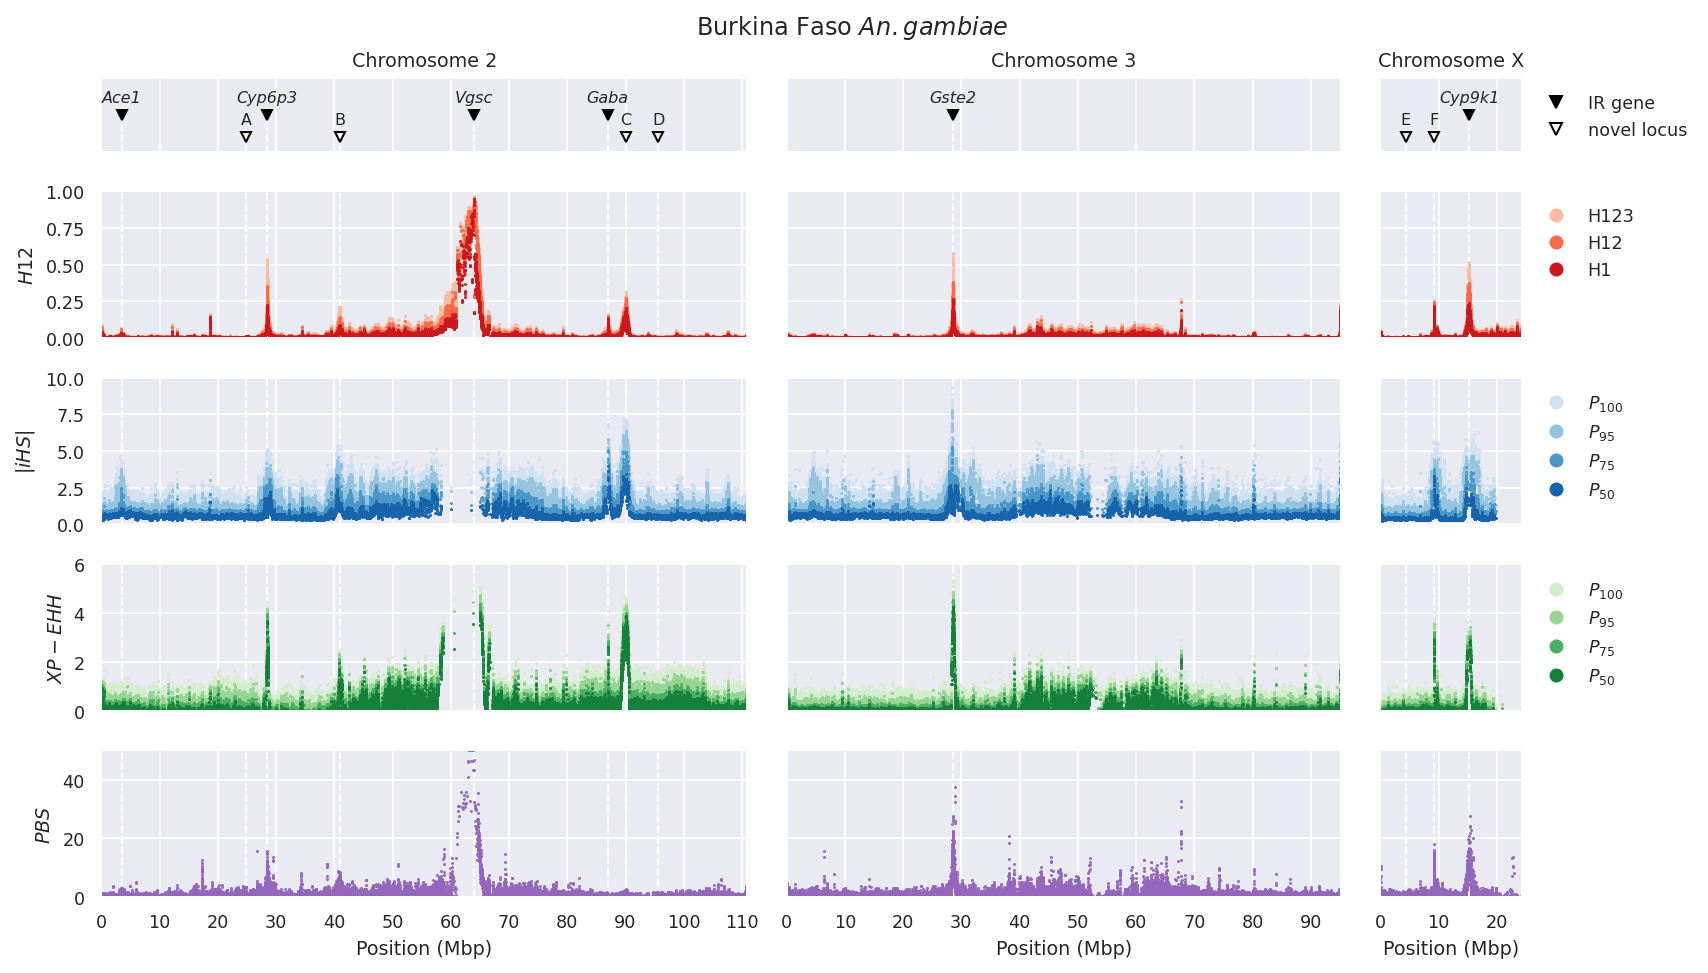

In [237]:
fig_gwss('bf_gam', xpehh_pop='gw', pbs_pops=('ug_gam', 'gq_gam'))

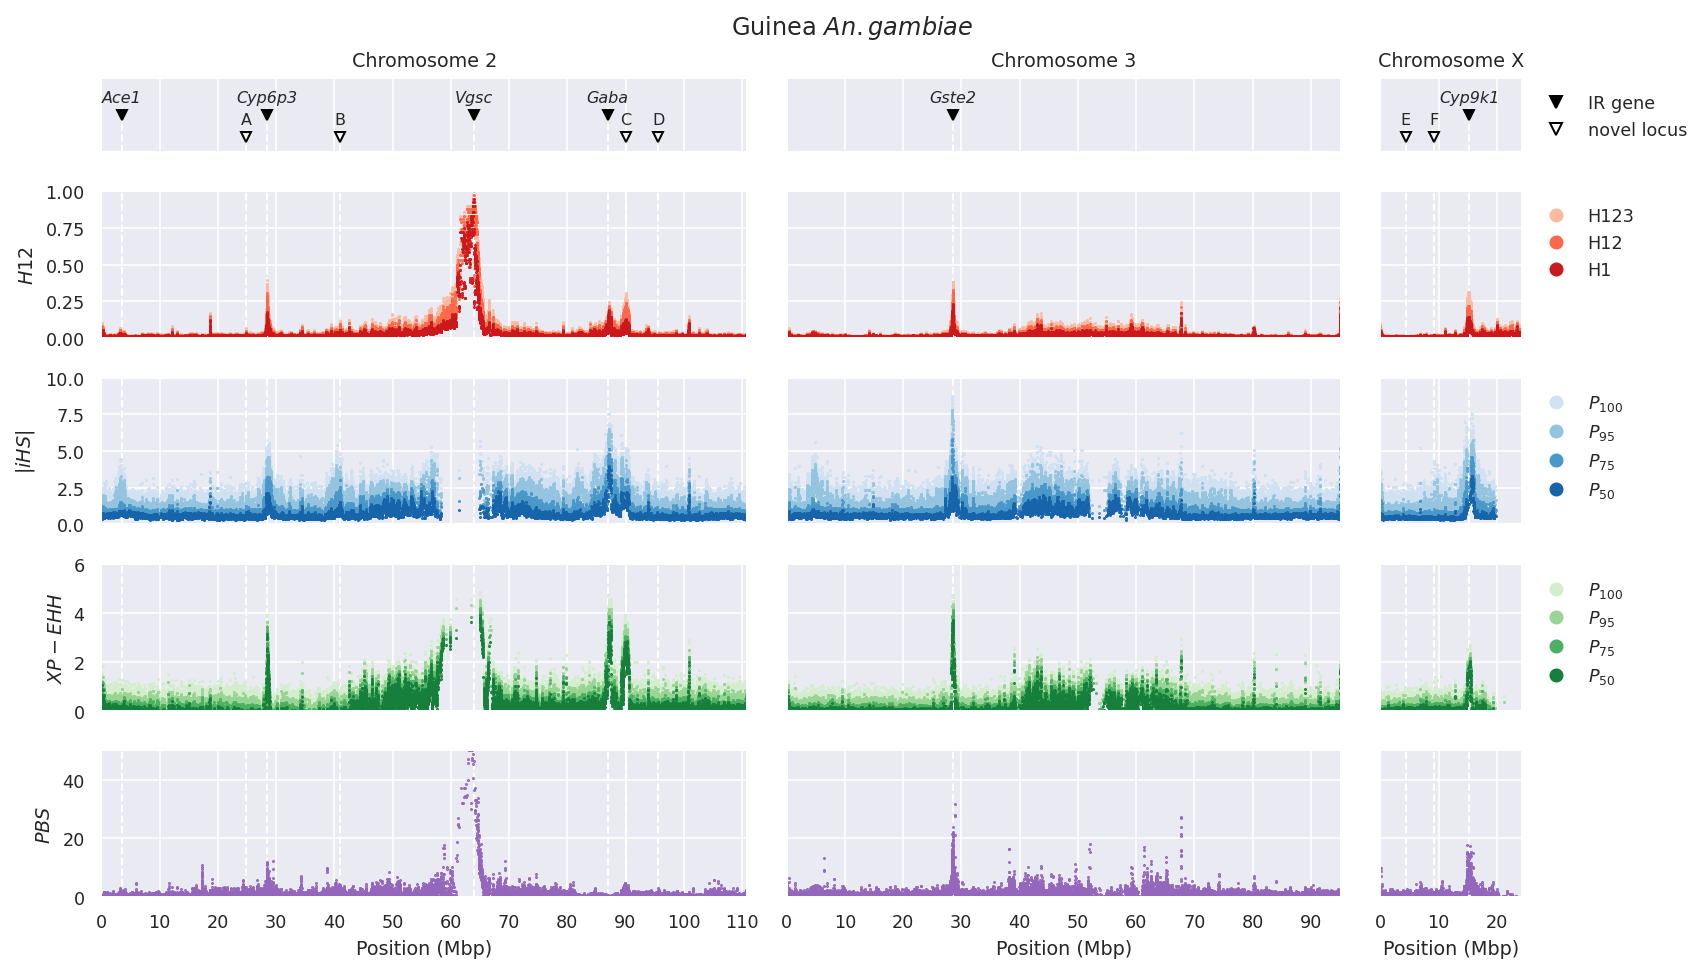

In [238]:
fig_gwss('gn_gam', xpehh_pop='gw', pbs_pops=('ug_gam', 'gq_gam'))